In [43]:
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [78]:
hyperlist = ["(32, 0.01)", "(32, 0.001)", "(32, 0.05)", "(32, 0.005)", "(64, 0.01)", "(64, 0.001)", "(64, 0.05)", "(64, 0.005)", "(128, 0.01)", "(128, 0.001)", "(128, 0.05)", "(128, 0.005)"]


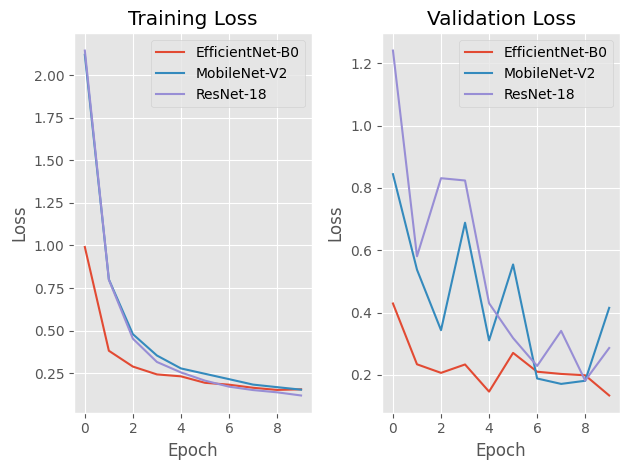

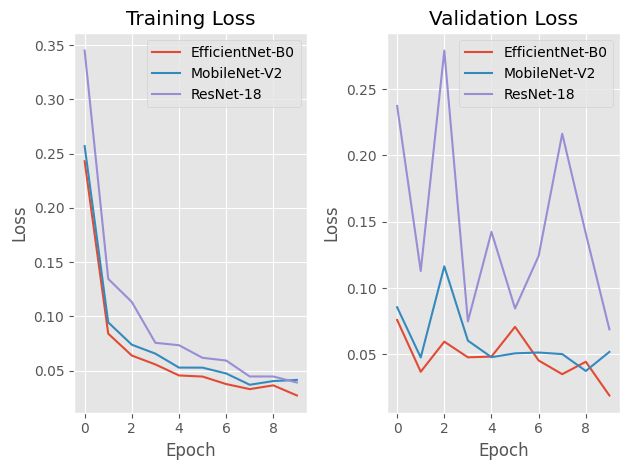

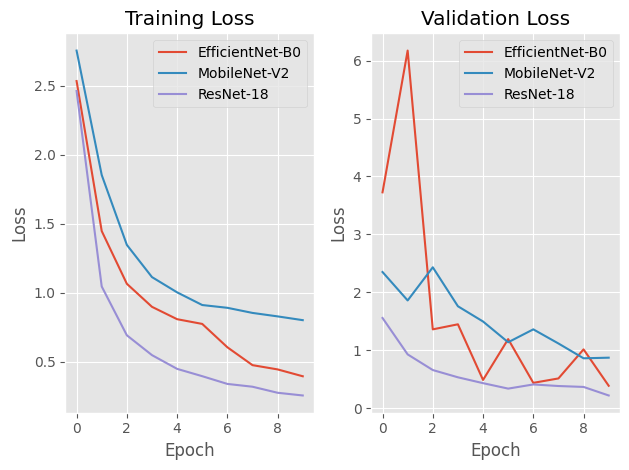

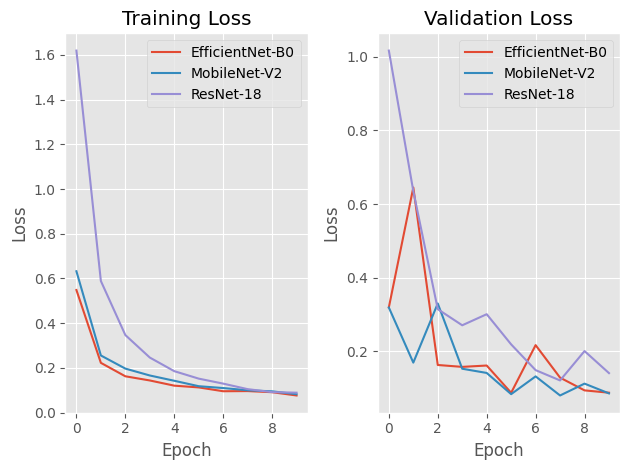

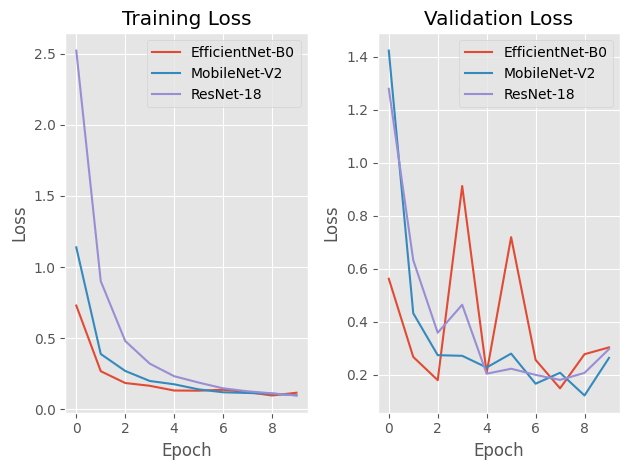

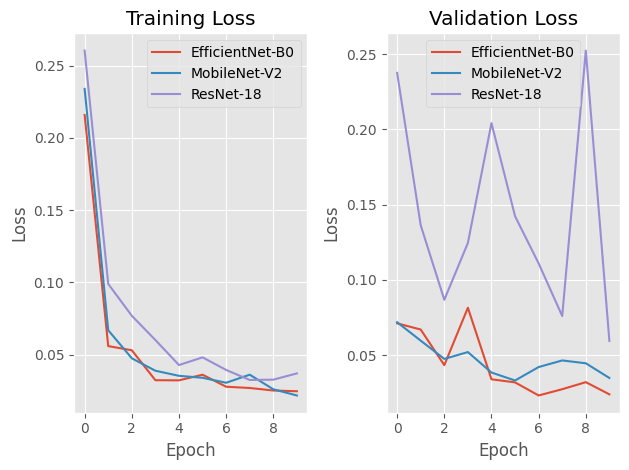

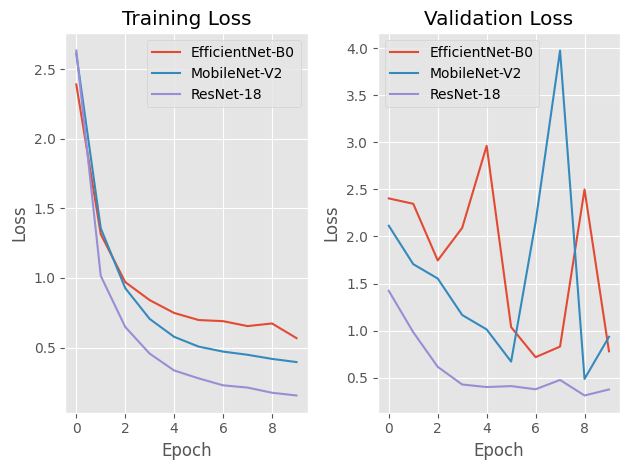

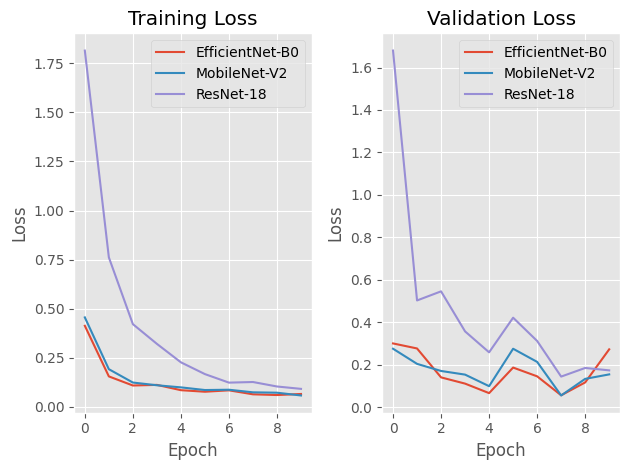

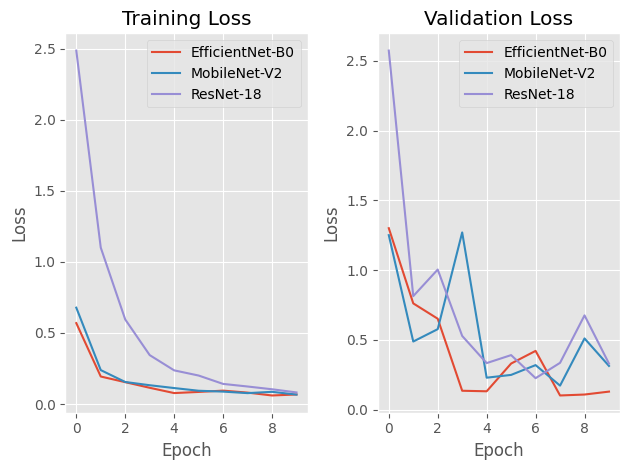

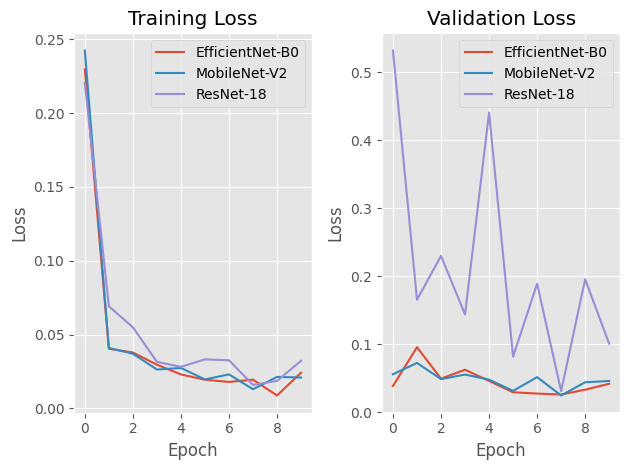

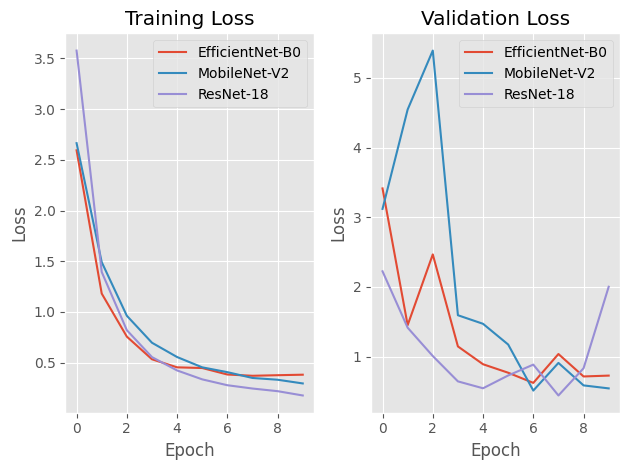

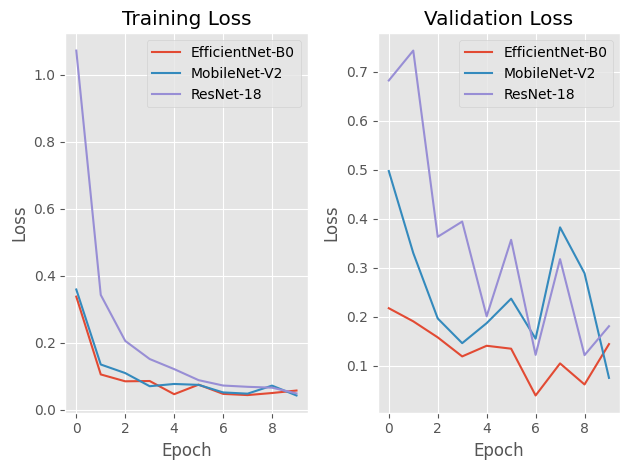

In [79]:
for param in hyperlist:
    efficient_path = "../Models/compared_csv/efficient_model"+param+".csv"
    mobile_path = "../Models/compared_csv/mobile_model"+param+".csv"
    resnet_path = "../Models/compared_csv/resnet_model"+param+".csv"
    
    efficient_csv = pd.read_csv(efficient_path)
    mobile_csv = pd.read_csv(mobile_path)
    resnet_csv = pd.read_csv(resnet_path)


    fig, ax = plt.subplots(1,2)
    ax[0].plot(efficient_csv["train_loss"])
    ax[0].plot(mobile_csv["train_loss"])
    ax[0].plot(resnet_csv["train_loss"])
    ax[0].set_title("Training Loss")
    ax[0].legend(["EfficientNet-B0", "MobileNet-V2", "ResNet-18"])
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Loss")

    ax[1].plot(efficient_csv["val_loss"])
    ax[1].plot(mobile_csv["val_loss"])
    ax[1].plot(resnet_csv["val_loss"])
    ax[1].set_title("Validation Loss")
    ax[1].legend(["EfficientNet-B0", "MobileNet-V2", "ResNet-18"])
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Loss")

    fig.tight_layout()

    save_path = "../Models/compared_graph/"+param+".png"
    fig.savefig(save_path)

    


    